References:

https://www.kaggle.com/code/sunyuanxi/surprise/notebook
https://surprise.readthedocs.io/en/stable/knn_inspired.html#actual-k-note
https://medium.com/analytics-vidhya/collaborative-based-recommendation-system-using-svd-9adc5b6b3b8
https://www.kaggle.com/code/bavalpreet26/recommender-system-part2/notebook
https://surprise.readthedocs.io/en/stable/getting_started.html
https://github.com/NicolasHug/Surprise/issues/20
https://learn.co/lessons/dsc-4-39-04-singular-value-decomposition-numpy-scipy-lab
https://medium.com/analytics-vidhya/collaborative-based-recommendation-system-using-svd-9adc5b6b3b8

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
import random
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import SVDpp
from surprise import NMF
from surprise import KNNBaseline
from surprise import BaselineOnly

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


**Feature Engineering - Creating a new date column**

In [5]:
df['date'] = pd.to_datetime(df['Time'], utc=False, unit='s')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21


In [6]:
df.dropna(inplace = True)

In [7]:
df['HelpfulnessNumerator'].unique()

array([  1,   0,   3,   4,   2,  19,  13,   9,  15,   5,  17,   8,   6,
         7,  43,  14,  11,  20,  27,  12,  10,  16,  21,  26,  23, 165,
        45,  30, 100,  32,  24,  22,  18,  59, 187,  29, 112, 107,  51,
        36,  25,  88,  35,  38,  42,  70,  86,  48,  34,  96,  53,  40,
        31,  65, 128,  97,  82,  37,  28, 202,  47, 149,  80,  77,  69,
        56,  39, 111,  60,  66,  44,  91, 115,  93, 180, 129,  58,  83,
        55,  62,  89,  50,  33, 135,  71, 157,  73, 122,  90,  81, 203,
       168,  64,  61, 398, 206, 133,  41,  84,  63,  95,  68, 110,  57,
        72,  52,  54,  49, 177,  46, 137, 286,  87, 264,  85, 258,  75,
       119, 123, 131, 125, 200, 536, 301,  78, 559, 472, 232, 294,  79,
        67, 154, 105,  74, 117, 113, 141, 162, 349, 130, 230, 189, 454,
       172, 116, 179, 138, 166, 142, 170, 247, 366, 106, 219,  94,  76,
        92, 413, 139, 866, 524, 233, 104, 844,  99, 144, 124, 491, 355,
       121, 192, 580, 102, 155, 436, 446, 262, 319, 103, 356, 43

In [8]:
df['HelpfulnessDenominator'].unique()

array([  1,   0,   3,   4,   2,   5,  19,  13,   9,   7,  15,   8,   6,
        10,  47,  17,  14,  27,  12,  11,  21,  31,  18,  23, 168,  46,
        30, 133,  16,  36,  25,  26,  24,  22,  29,  20,  64, 216,  33,
       112, 108,  51,  37,  39,  89,  35,  43,  42,  74,  49,  34,  28,
        53,  96,  58,  41,  65, 130, 100,  84,  38,  40,  32,  48, 219,
       155,  83,  85,  72,  56,  63, 128,  79,  76,  55,  68,  66,  44,
        94,  59, 117, 188, 134,  92,  57,  71,  98,  90,  45, 135, 170,
        77,  52, 123,  50,  93,  88, 122, 212, 192, 120, 401, 209,  95,
        86,  99,  73,  60, 124,  54,  61,  70, 180,  91,  81, 138, 163,
       307, 270, 151,  78,  62, 119, 139, 137, 215, 539, 305, 562, 477,
       235,  87,  69, 298,  75,  82, 103, 156, 110, 144,  80,  67, 127,
       162, 181, 356, 245, 462, 174, 111, 182, 143, 179, 159, 101, 171,
        97, 249, 384, 187, 121, 263, 131, 165, 416, 106, 878, 536, 238,
       109, 923, 115, 150, 371, 105, 154, 125, 149, 569, 360, 22

In [9]:
df['Score'].unique()

array([5, 1, 4, 2, 3], dtype=int64)

C:\Users\sasid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


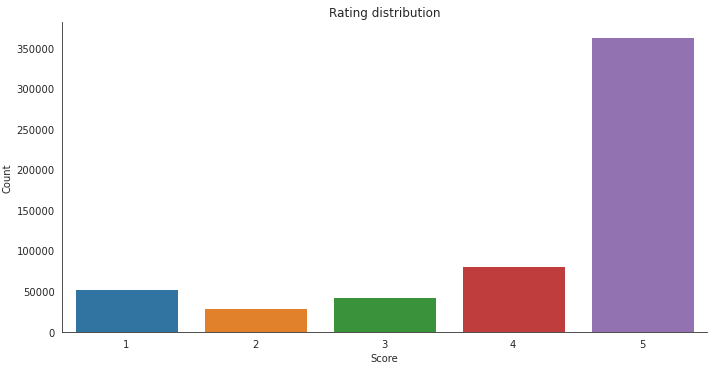

In [10]:
with sns.axes_style('white'):
    plot = sns.catplot("Score", data=df, aspect=2.0,kind='count').set(title='Rating distribution')
    plot.set_ylabels("Count")

In [11]:
df12 = df['Score'].astype('category').value_counts()
df12.to_frame().style.background_gradient(cmap='PuBuGn')

,Score
5,363111
4,80655
1,52264
3,42638
2,29743


In [12]:
df1 = df.copy()

In [13]:
df1=df1.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)

In [14]:
df1.head(5).style.background_gradient(cmap='YlOrRd')

,Score,Text,date
0,5,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,2011-04-27 00:00:00
1,1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",2012-09-07 00:00:00
2,4,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",2008-08-18 00:00:00
3,2,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,2011-06-13 00:00:00
4,5,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",2012-10-21 00:00:00


In [15]:
dfdate = df.copy()
dfdate=dfdate.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text'],axis=1)

In [16]:
dfdate['year'] = pd.DatetimeIndex(dfdate['date']).year
dfdate['dow'] = pd.DatetimeIndex(dfdate['date']).weekday
dfdate['month']= pd.DatetimeIndex(dfdate['date']).month
dfdate

,Score,date,year,dow,month
0,5,2011-04-27,2011,2,4
1,1,2012-09-07,2012,4,9
2,4,2008-08-18,2008,0,8
3,2,2011-06-13,2011,0,6
4,5,2012-10-21,2012,6,10
...,...,...,...,...,...
568449,5,2011-03-09,2011,2,3
568450,2,2012-03-09,2012,4,3
568451,5,2012-02-21,2012,1,2
568452,5,2012-03-13,2012,1,3


In [17]:
dfdate['dow'] = dfdate['dow'].replace({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})
dfdate['month'] = dfdate['month'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

C:\Users\sasid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


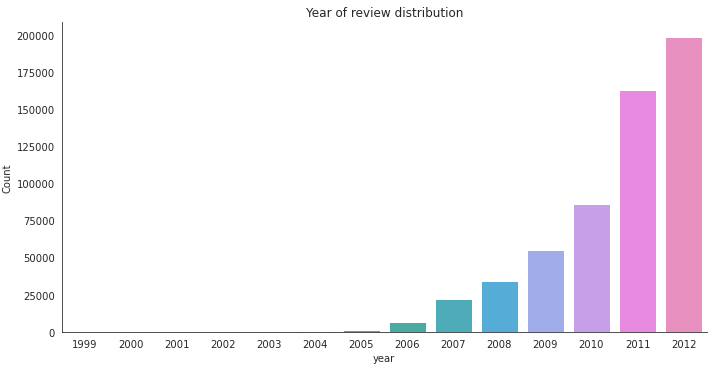

In [18]:
with sns.axes_style('white'):
    plot = sns.catplot("year", data=dfdate, aspect=2.0,kind='count').set(title='Year of review distribution')
    plot.set_ylabels("Count")

In [19]:
pd.crosstab(dfdate['year'],dfdate['Score'],rownames = ['Year'])

Score,1,2,3,4,5
Year,,,,,
1999,0,0,0,0,6
2000,3,0,0,3,26
2001,3,1,1,2,6
2002,0,3,0,12,58
2003,10,2,8,27,85
2004,48,10,18,83,402
2005,59,83,53,149,991
2006,523,260,428,852,4608
2007,1249,890,1326,3180,15630


C:\Users\sasid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


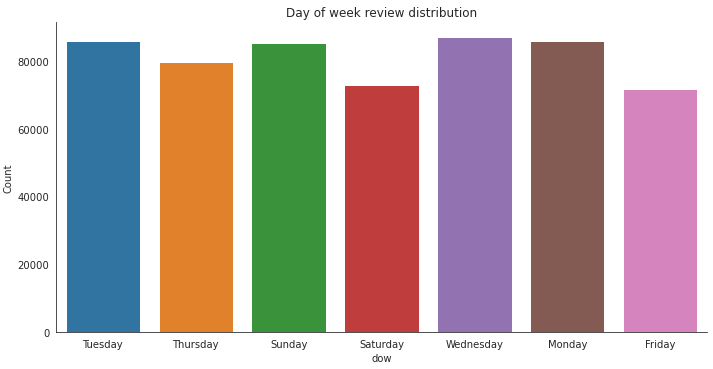

In [20]:
with sns.axes_style('white'):
    plot = sns.catplot("dow", data=dfdate, aspect=2.0,kind='count').set(title='Day of week review distribution')
    plot.set_ylabels("Count")

In [21]:
pd.crosstab(dfdate['dow'],dfdate['Score'],rownames = ['Day'])

Score,1,2,3,4,5
Day,,,,,
Friday,6640,3591,5172,9572,46709
Monday,7757,4596,6557,12308,54633
Saturday,6425,3441,4845,10100,47980
Sunday,7822,4521,6071,12009,54938
Thursday,7408,4172,5939,10915,51245
Tuesday,8147,4717,6812,12406,53911
Wednesday,8065,4705,7242,13345,53695


C:\Users\sasid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


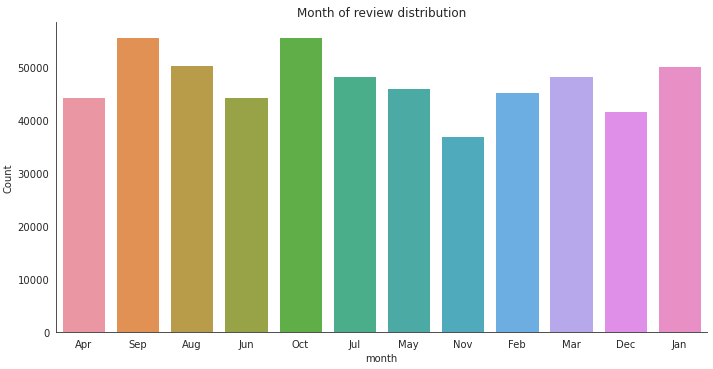

In [22]:
with sns.axes_style('white'):
    plot = sns.catplot("month", data=dfdate, aspect=2.0,kind='count').set(title='Month of review distribution')
    plot.set_ylabels("Count")

In [23]:
pd.crosstab(dfdate['month'],dfdate['Score'],rownames = ['Month'])

Score,1,2,3,4,5
Month,,,,,
Apr,3856,2257,3367,6640,28352
Aug,4578,2643,3672,7369,32261
Dec,4438,2185,3190,5610,26323
Feb,4159,2440,3493,6247,29016
Jan,4963,2689,3386,6638,32690
Jul,4277,2517,3787,7092,30745
Jun,4098,2422,3414,6642,27903
Mar,4182,2620,3870,7159,30510
May,4040,2246,3375,6884,29681


<AxesSubplot:xlabel='ProductId'>

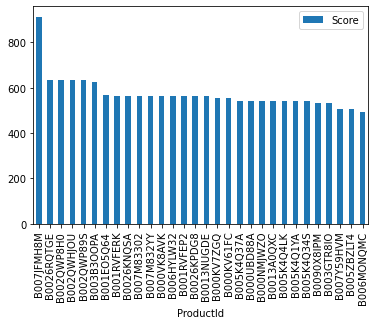

In [24]:
top_products = pd.DataFrame(df.groupby('ProductId')['Score'].count())
top_products = top_products.sort_values('Score',ascending = False)
top_products.head(30).plot(kind = "bar")

<AxesSubplot:xlabel='UserId'>

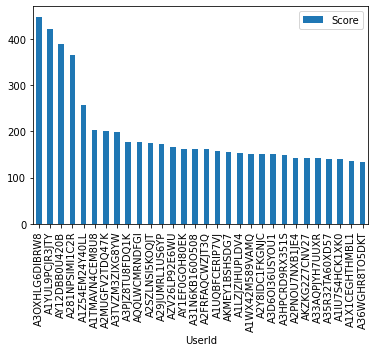

In [25]:
top_users = pd.DataFrame(df.groupby('UserId')['Score'].count())
top_users = top_users.sort_values('Score',ascending = False)
top_users.head(30).plot(kind = "bar")

[Text(0.5, 1.0, 'HelpfulnessNumerator vs Score')]

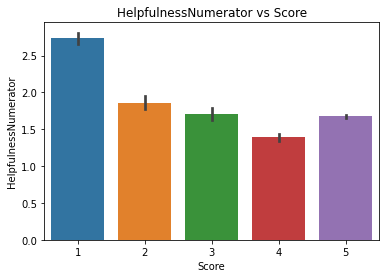

In [26]:
sns.barplot(data=df,y='HelpfulnessNumerator',x='Score').set(title='HelpfulnessNumerator vs Score')

[Text(0.5, 1.0, 'HelpfulnessDenominator vs Score')]

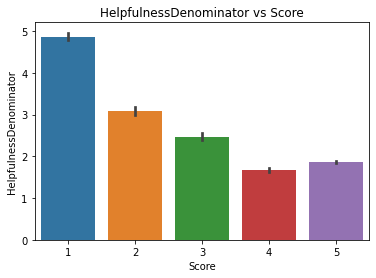

In [27]:
sns.barplot(data=df,y='HelpfulnessDenominator',x='Score').set(title='HelpfulnessDenominator vs Score')

[Text(0.5, 1.0, 'HelpfulnessNumerator vs HelpfulnessDenominator')]

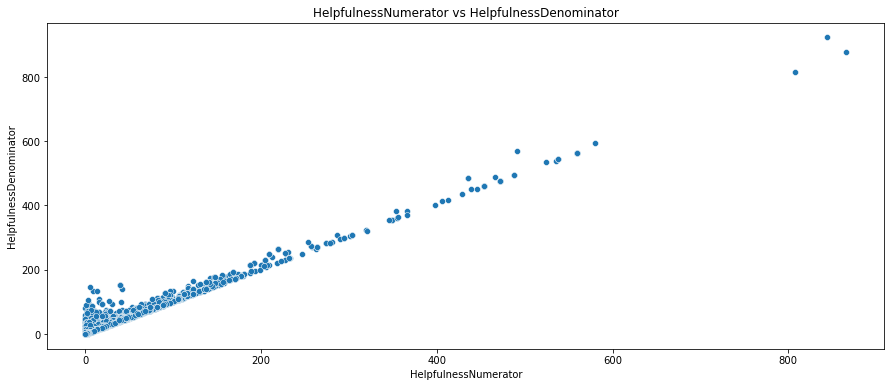

In [28]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=df,y='HelpfulnessDenominator',x='HelpfulnessNumerator').set(title='HelpfulnessNumerator vs HelpfulnessDenominator')

In [29]:
def tokenizer(Text):
    tokens = nltk.word_tokenize(Text)
    tokens = [w for w in tokens if w.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]
    words = ( " ".join(words))
    return words

In [30]:
df['Text'] = df['Text'].apply(tokenizer)

In [31]:
def wordcloud(Text):
    wordcloud = WordCloud(background_color='white',width = 3000,height = 3000).generate(str(Text))
    fig = plt.figure(figsize = (20, 20),facecolor = 'k',edgecolor = 'k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

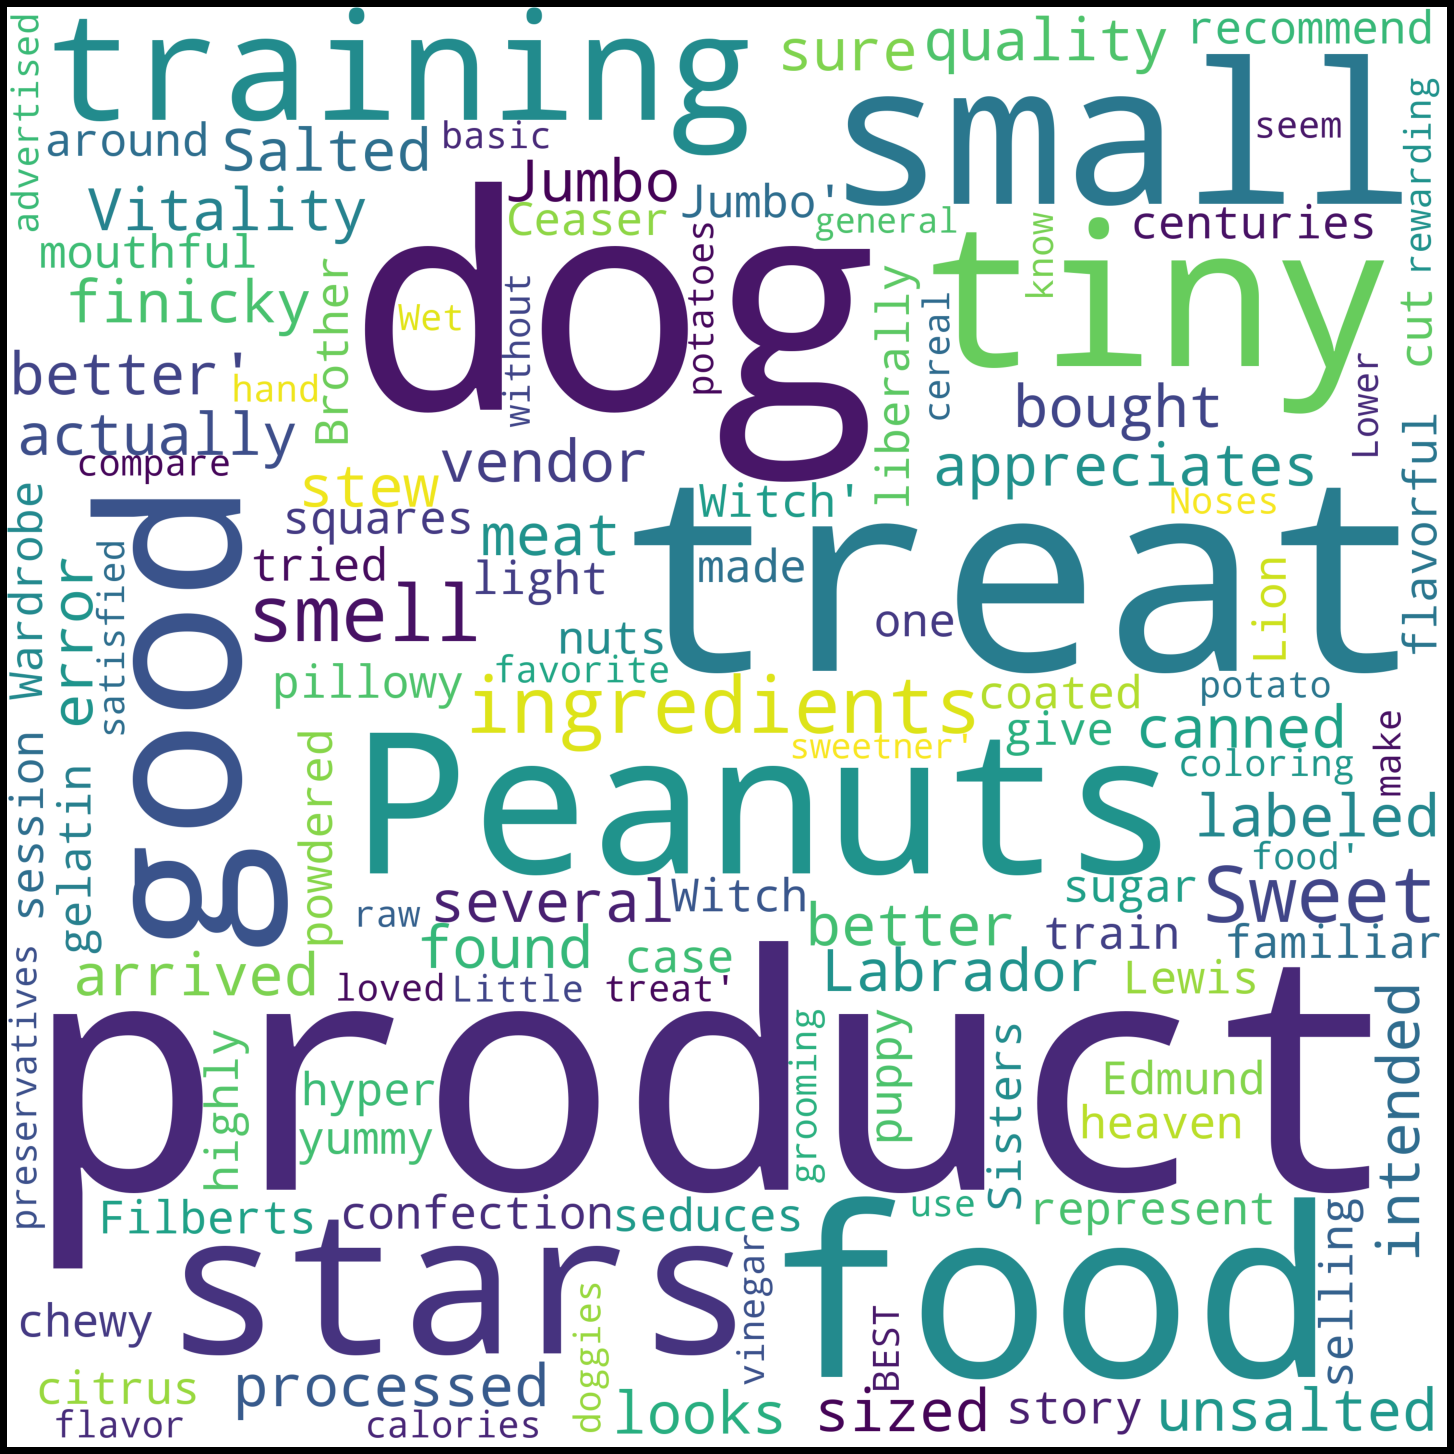

In [32]:
df33 = df.Text.values
wordcloud(df33)

In [33]:
recommendations=df[['ProductId','UserId','Score']]
recommendations

,ProductId,UserId,Score
0,B001E4KFG0,A3SGXH7AUHU8GW,5
1,B00813GRG4,A1D87F6ZCVE5NK,1
2,B000LQOCH0,ABXLMWJIXXAIN,4
3,B000UA0QIQ,A395BORC6FGVXV,2
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5
...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,5
568450,B003S1WTCU,A3I8AFVPEE8KI5,2
568451,B004I613EE,A121AA1GQV751Z,5
568452,B004I613EE,A3IBEVCTXKNOH,5


In [34]:
recommendations=recommendations.groupby(by=['ProductId','UserId'],as_index=False).agg({'Score':'mean'})
recommendations

,ProductId,UserId,Score
0,0006641040,A12HY5OZ2QNK4N,5.0
1,0006641040,A1C9K534BCI9GO,4.0
2,0006641040,A1DJXZA5V5FFVA,5.0
3,0006641040,A1HKYQOFC8ZZCH,1.0
4,0006641040,A1IJKK6Q1GTEAY,5.0
...,...,...,...
560756,B009UOFTUI,AJVB004EB0MVK,1.0
560757,B009UOFU20,AJVB004EB0MVK,1.0
560758,B009UUS05I,ARL20DSHGVM1Y,5.0
560759,B009WSNWC4,AMP7K1O84DH1T,5.0


In [35]:
recommendations.reset_index(drop =True, inplace = True)
recommendations

,ProductId,UserId,Score
0,0006641040,A12HY5OZ2QNK4N,5.0
1,0006641040,A1C9K534BCI9GO,4.0
2,0006641040,A1DJXZA5V5FFVA,5.0
3,0006641040,A1HKYQOFC8ZZCH,1.0
4,0006641040,A1IJKK6Q1GTEAY,5.0
...,...,...,...
560756,B009UOFTUI,AJVB004EB0MVK,1.0
560757,B009UOFU20,AJVB004EB0MVK,1.0
560758,B009UUS05I,ARL20DSHGVM1Y,5.0
560759,B009WSNWC4,AMP7K1O84DH1T,5.0


In [36]:
users = pd.DataFrame(recommendations['UserId'].value_counts()).reset_index()
users

,index,UserId
0,A3OXHLG6DIBRW8,420
1,AY12DBB0U420B,382
2,A281NPSIMI1C2R,321
3,A1YUL9PCJR3JTY,309
4,A1Z54EM24Y40LL,251
...,...,...
256042,A9EM8EP324CJM,1
256043,ATOW5T3WJJP0G,1
256044,A1QDRPF45BPJY1,1
256045,AL5PV3PSL0QD4,1


In [37]:
users_list = list(users['index'].unique())

In [38]:
len(users_list)

256047

In [39]:
random.seed(10)
users_list = random.sample(users_list, 20000)

In [40]:
len(users_list)

20000

In [41]:
recommendations = recommendations[recommendations.UserId.isin(users_list)]

In [42]:
recommendations

,ProductId,UserId,Score
8,0006641040,A2IW4PEEKO2R0U,4.0
16,0006641040,A3CMRKGE0P909G,5.0
25,0006641040,ACITT7DI6IDDL,5.0
26,0006641040,ADBFSA9KTQANE,5.0
27,0006641040,AGQWHPNDZGUD0,3.0
...,...,...,...
560682,B009RB4GO4,AEZ49I33XW2VE,1.0
560692,B009RB4GO4,AK24K0FH4PK86,1.0
560731,B009RSR8HO,A4P6AN2L435PV,5.0
560737,B009SA5NNW,A1PVBIUKEDNGVP,5.0


In [47]:
matrix = recommendations.pivot(index = 'UserId', columns ='ProductId', values = 'Score').fillna(0)
matrix 

ProductId,0006641040,2734888454,7310172001,7310172101,B00002N8SM,B00002NCJC,B00004CI84,B00004CXX9,B00004RAMS,B00004RAMX,...,B009M4JDWQ,B009NIF7BM,B009NN54I8,B009PCDDO4,B009QEBGIQ,B009QNJRSS,B009RB4GO4,B009RSR8HO,B009SA5NNW,B009SF0TN6
UserId,,,,,,,,,,,,,,,,,,,,,
#oc-R103C0QSV1DF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#oc-R11DNU2NBKQ23Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#oc-R1669TSD0WO7EP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#oc-R19B7LHEK1ARMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#oc-R1GSBW9QIVY489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZYJJA10OOIMR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZ556B2VPA1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZ58AJ3HJCK8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User Recommendations

**Implementing a Cosine Similarity based recommendation system**

In [51]:
cosine_sim = cosine_similarity(matrix)

In [52]:
cosine_sim.shape

(20000, 20000)

In [53]:
similarity_scores = list(enumerate(cosine_sim))

In [54]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [55]:
matrix1 = matrix.reset_index()
matrix1

ProductId,UserId,0006641040,2734888454,7310172001,7310172101,B00002N8SM,B00002NCJC,B00004CI84,B00004CXX9,B00004RAMS,...,B009M4JDWQ,B009NIF7BM,B009NN54I8,B009PCDDO4,B009QEBGIQ,B009QNJRSS,B009RB4GO4,B009RSR8HO,B009SA5NNW,B009SF0TN6
0,#oc-R103C0QSV1DF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,#oc-R11DNU2NBKQ23Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,#oc-R1669TSD0WO7EP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,#oc-R19B7LHEK1ARMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,#oc-R1GSBW9QIVY489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,AZYJJA10OOIMR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,AZZ556B2VPA1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,AZZ58AJ3HJCK8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,AZZH3GGYQSBUC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
index = matrix1['UserId'].tolist()

In [57]:
matrix1.drop(columns = ['UserId'],inplace = True)
matrix1

ProductId,0006641040,2734888454,7310172001,7310172101,B00002N8SM,B00002NCJC,B00004CI84,B00004CXX9,B00004RAMS,B00004RAMX,...,B009M4JDWQ,B009NIF7BM,B009NN54I8,B009PCDDO4,B009QEBGIQ,B009QNJRSS,B009RB4GO4,B009RSR8HO,B009SA5NNW,B009SF0TN6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
def similiar_users(matrix,data,indexes,user_id):
    lst=[matrix.index[i] for i in indexes if i != user_id]
    users=[index[i] for i in lst]
    print('The similar users for the above UserId, based on their ratings is {}'.format(users))

In [59]:
def top_cosine_similarity(data, user_id, top_n=10):
    row = data.loc[user_id, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[user_id] * magnitude)
    return np.argsort(-similarity)[1:top_n+1]

**Getting 10 similar users for the given user : A10123JRH5MVEA**

In [60]:
k = 30
user_id=matrix1.index[50]
top_n = 10
print('The given UserId is : {}'.format(index[user_id]))
indexes = top_cosine_similarity(matrix1,user_id,top_n)
similiar_users(matrix1,recommendations, indexes,user_id)

The given UserId is : A10123JRH5MVEA
The similar users for the above UserId, based on their ratings is ['A3F20TLZIS4VRY', 'A151AUGCSXA18H', 'A1P0S2FVBUXTF6', 'ATREKVFZ4P3N', 'AO5WLEFYKL5T2', 'A1JFNZ4UAMEZN3', 'A3IADNY5QO1LZX', 'A3IAP9SMS6DPFZ', 'A3IEDM84ASW3QW']


In [61]:
def similiar_users(matrix,data,indexes,user_id,df):
    rev = []
    lst=[matrix.index[i] for i in indexes]
    users=[index[i] for i in lst]
    for i in users:
        reviews = df.loc[df['UserId']== i,'Text'].values[0]
        rev.append(reviews)
    return rev

In [62]:
reviews = similiar_users(matrix1,recommendations, indexes,user_id,df)

In [63]:
#nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sasid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
reviews = pd.DataFrame(reviews).reset_index()
reviews

,index,0
0,0,I purchased alternative Gerber fruit strips to...
1,1,My kids picky fruit strips favorite treat Now ...
2,2,If looking yummy chewy treat I would suggest s...
3,3,Great deal great taste So much cheaper buying ...
4,4,My son loves snacks lunch car rides I used buy...
5,5,I used get Gerber fruit strips kids expensive ...
6,6,best tasting salt I ever tried The mineral con...
7,7,I friend turn coconut water running high amoun...
8,8,Be VERY careful eating cereal There tiny dried...
9,9,I buying Johnny Seasoning Salt years perfect a...


In [65]:
reviews['filtered']= reviews[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and word.isalpha()]))

In [66]:
tfidf_vec = TfidfVectorizer()
tokens = tfidf_vec.fit_transform(reviews['filtered'])
terms = tfidf_vec.get_feature_names()
hc = tokens.toarray()

In [67]:
hc.shape

(10, 275)

**Clustering the 10 users that are similar to the user A10123JRH5MVEA**

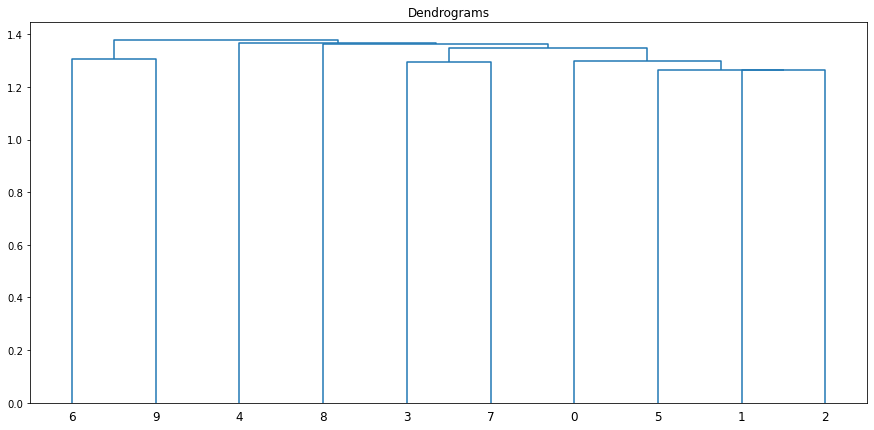

In [68]:
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(hc, method='single'))

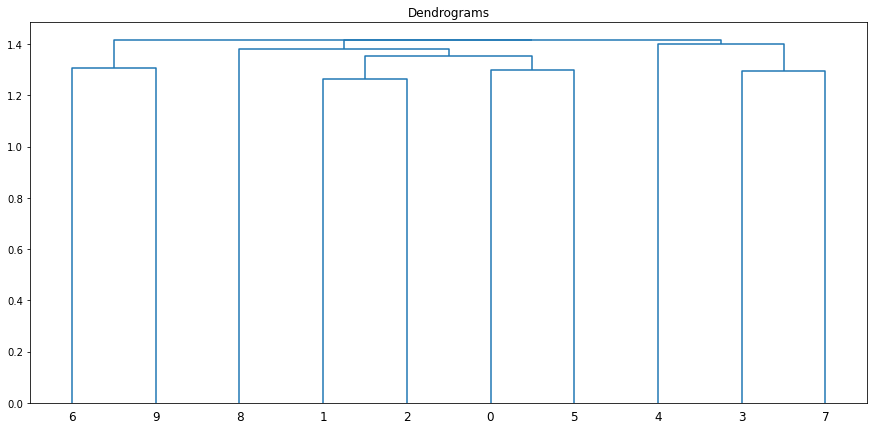

In [69]:
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(hc, method='complete'))

In [70]:
recommendations.head()

,ProductId,UserId,Score
8,0006641040,A2IW4PEEKO2R0U,4.0
16,0006641040,A3CMRKGE0P909G,5.0
25,0006641040,ACITT7DI6IDDL,5.0
26,0006641040,ADBFSA9KTQANE,5.0
27,0006641040,AGQWHPNDZGUD0,3.0


In [71]:
recommendations = pd.DataFrame(recommendations)
recommendations

,ProductId,UserId,Score
8,0006641040,A2IW4PEEKO2R0U,4.0
16,0006641040,A3CMRKGE0P909G,5.0
25,0006641040,ACITT7DI6IDDL,5.0
26,0006641040,ADBFSA9KTQANE,5.0
27,0006641040,AGQWHPNDZGUD0,3.0
...,...,...,...
560682,B009RB4GO4,AEZ49I33XW2VE,1.0
560692,B009RB4GO4,AK24K0FH4PK86,1.0
560731,B009RSR8HO,A4P6AN2L435PV,5.0
560737,B009SA5NNW,A1PVBIUKEDNGVP,5.0


In [72]:
df_new = recommendations.copy()

In [73]:
df_new.columns = ['itemID', 'userID', 'rating']

In [74]:
recommendations = df_new.copy()
recommendations.head()

,itemID,userID,rating
8,0006641040,A2IW4PEEKO2R0U,4.0
16,0006641040,A3CMRKGE0P909G,5.0
25,0006641040,ACITT7DI6IDDL,5.0
26,0006641040,ADBFSA9KTQANE,5.0
27,0006641040,AGQWHPNDZGUD0,3.0


In [75]:
#recommendations = pd.DataFrame(recommendations)
reader = Reader()
data = Dataset.load_from_df(recommendations, reader=reader)

In [76]:
svd_df = data.build_full_trainset()
svd_df

In [77]:
params = {'n_factors' :[20,50,100],
         'reg_all':[0.02,0.05,0.1]}

In [78]:
svd = SVD()
gridsearch = GridSearchCV(SVD, params, measures=['rmse'], cv=3)

In [79]:
gridsearch.fit(data)

In [80]:
gridsearch.best_params['rmse']

{'n_factors': 20, 'reg_all': 0.02}

**Implementing a for loop to find the best model**

In [81]:
results = []
for i in [SVD(), SVDpp(), NMF(), KNNBaseline(),BaselineOnly()]:
    
    op = cross_validate(i, data, measures=['RMSE'], cv=3, verbose=False)
    
    x = pd.DataFrame.from_dict(op).mean(axis=0)
    x = x.append(pd.Series([str(i).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    results.append(x)
    
pd.DataFrame(results).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.072512,2.793663,0.130227
SVDpp,1.130172,2.942381,0.125000
SVD,1.188844,1.126602,0.052070
BaselineOnly,1.198309,0.062506,0.041659
NMF,1.231064,2.442430,0.088525


**From the above code, KNNBaseline is found to be the best model with the lowest test rmse of 1.072**

**Implementing a Gridsearch to find the best parameters for the KNNBaseline model**

In [82]:
params = {'k' :[10,20,30,40],
         'min_k':[1,2,3,4,5]}

In [83]:
gridsearch = GridSearchCV(KNNBaseline, params, measures=['rmse'], cv=3)

In [84]:
gridsearch.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [85]:
gridsearch.best_params['rmse']

{'k': 10, 'min_k': 1}

In [86]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25)

In [87]:
trainset, testset = train_test_split(data, test_size=.25)

In [88]:
knn = KNNBaseline(k=10, min_k =1)

In [89]:
knn.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [90]:
pred = knn.test(testset)

In [91]:
accuracy.rmse(pred)

RMSE: 1.0646


1.064647411858257

**After gridsearch, the rmse has dropped from 1.072 to 1.064 for the KNNBaseline model**

### Product Recommendations

**Using the best model to perform product recommendations for a user**

In [102]:
reader = Reader()
data = Dataset.load_from_df(recommendations.head(10000), reader)

In [114]:
final_df=pd.DataFrame()
product_id = recommendations['itemID'].unique()#Selecting the item id from our initial recommendations dataframe
knn = KNNBaseline(k=10, min_k =1)
for i in recommendations['userID'].unique()[:50]: #iterating for every user(limiting to 50)
    iids = recommendations.loc[recommendations['userID']==i, 'itemID']#Based on the user id, the corresponding item id is located
    items = np.setdiff1d(product_id,iids)
    knn.fit(data.build_full_trainset())
    recs = []
    for iid in items:
        recs.append((iid, knn.predict(uid=i,iid=iid).est,i))# using the above item id and user id to make predictions using the best model

    preds_df=pd.DataFrame(recs, columns=['iid', 'predictions','user_id']).sort_values('predictions', ascending=False)
    preds_df=preds_df.drop_duplicates()
    final_df=pd.concat([final_df,preds_df[:10]],axis=0)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [113]:
final_df.head(5)

,index,iid,predictions,user_id
0,0,2734888454,4.218258,A2IW4PEEKO2R0U
1,12760,B002Y2QTEI,4.218258,A2IW4PEEKO2R0U
2,12758,B002Y2QSMQ,4.218258,A2IW4PEEKO2R0U
3,12757,B002Y2QSBW,4.218258,A2IW4PEEKO2R0U
4,12756,B002Y2QS0S,4.218258,A2IW4PEEKO2R0U


**Final 10 product recommendations for the user A3CMRKGE0P909G**

In [110]:
final_df1=final_df[final_df['user_id']== 'A3CMRKGE0P909G']
product_recommendations=recommendations[recommendations['itemID'].isin(final_df1['iid'])]['itemID'].unique().tolist()
product_recommendations

['2734888454',
 'B002Y2E7NS',
 'B002Y2OWDS',
 'B002Y2OWII',
 'B002Y2OWOC',
 'B002Y2OWRY',
 'B002Y2QS0S',
 'B002Y2QSBW',
 'B002Y2QSMQ',
 'B002Y2QTEI']